# Vasicek and CIR models 

In this post, I discuss how to implement in Python the price of a Zero Coupon Bond with two very famous short term interest rate models, Vasicek and CIR

Under the Vasicek and CIR model, the short rate is respectively assumed to satisfy the following stochastic diﬀerential equations

$$ dr_t = k(\theta - r_0)dt + \sigma dW_t  $$

and

$$ dr_t = k(\theta - r_0)dt +\sigma \sqrt r_t dW_t $$ 

where $k$, $\theta$ and $\sigma $ are constants, and $r_0$ is
the current level of (short term) interest rates

### Vasicek model

The Vasicek model provides an analytical expression for the price of a zero coupon bond:

\begin{equation}
P(0,\tau) = A(\tau) exp^{-B(\tau)r_0}
\end{equation}
<br>
\begin{equation}
A(\tau) = exp{\left[{{\left(\theta-\frac{\sigma^2}{2k^2}\right)}(B(\tau)-\tau) }-\frac{\sigma^2B^2(\tau)}{4k}\right]}
\end{equation}
<br>
\begin{equation}
B(\tau) = \frac{1-e^{-k\tau}}{k}
\end{equation}

### CIR model

The corresponding expression in the CIR is:

\begin{equation}
P(0,\tau) = A(\tau) exp^{-B(\tau)r_0}
\end{equation}
<br>
\begin{equation}
A(\tau) = {\left(\frac{2he^{0.5(h+\tau)}}{2h+(h+k)(e^{h\tau}-1)}\right)}^{2k\theta/\sigma^2}
\end{equation}
<br>
\begin{equation}
B(\tau) = \frac{2(e^{h\tau}-1)}{2h+(h+k)(e^{h\tau}-1)}
\end{equation}
<br>
\begin{equation}
h = \sqrt{k^2+2\sigma^2}
\end{equation}

### zero and forward rate under continuous compounding

The zero rate for a term $\tau$ is equal to

\begin{equation}
s(\tau) = -\frac{log{P(0,\tau)}}{\tau}
\end{equation}

whereas the forward rate can be obtained with one of the following equivalent formulae

\begin{equation}
f(\tau) = s(\tau) + \tau \frac{ds(\tau)}{d\tau}
\end{equation}

\begin{equation}
f(\tau) = \frac{\frac{dP(0,\tau)}{d\tau}}{P(0,\tau)}
\end{equation}

\begin{equation}
f(\tau) = \frac{dlog(P(0,\tau))}{d\tau}
\end{equation}


### Price of a zero coupon bond with forward rates

The zero coupon bond price can be reconstructed using the forward rate as follows

$$ P(0, \tau) = \exp\left(-\int_0^{\tau}f(s)ds\right)$$

### Price of a zero coupon bond with simulating the short term interest rate

I started by writing the sde's for both vasicek and cir model, and so I can also use the expectation of the discount factors from the sample of Monte-Carlo paths, to calculate the zero coupon bond price.

$$P^{MC}(0,\tau) = E_0\left\{ e^{-\int_0^{\tau} r^{MC}(u) du} \right\}$$

where $r^{MC}(u)$ is the simulated path of the short term rate under the vasicek or cir model

### Python implementation

In python I implemented a $super$ class Bond, to deal with the calculation of the zero and forward rates, as well as calculating the monte carlo price. 

There are two $derived$ classes, $Vasicek$ and $CIR$,  which I use to $delegate$ the simulation of the short term rate $r_t$ with an $Euler$ scheme, and calculate the analytical price of a zcb under their respective sde's. They also contains some sanity checks methods, to ensure that the simulated paths are in line with the exptected short term rate  

### class Bond 

In [1]:
import numpy as np
import numpy.random as npr
import scipy.integrate as sciIntegr
from scipy import integrate

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Bond(object):
    def __init__(self, theta, kappa, sigma, r0=0.):
        '''
        r0    is the current level of rates
        kappa is the speed of convergence
        theta is the long term rate
        sigma is the volatility    
        '''
        self.theta = theta
        self.kappa = kappa
        self.sigma = sigma
        self.r0    = r0
        self.dt    = 0.001
        
    def Exact_zcb(self, tau):
        pass
    
    def Euler(self, M, I, tau):
        pass
    
    def SpotRate(self, time) :
        price = self.Exact_zcb(time)    
        return (-np.log(price)/time)
    
    def Forward_rate_Integral1(self, time, time_frd):    
        def forward(time):
            up   = np.max(time + self.dt,0)
            down = np.max(time - self.dt,0)        
            
            r        = self.SpotRate(time)                        
            dr       = self.SpotRate(up) - self.SpotRate(down)
            dr_dt    = dr/(2*self.dt)         
            fwd_rate = r + time * dr_dt
            return fwd_rate
    
        val = integrate.quad(forward, time, time_frd)[0]
        return val

    def Forward_rate_Integral2(self, time, time_frd):            
        def forward(time):            
            up   = np.max(time + self.dt,0)
            down = np.max(time - self.dt,0)
    
            dP       = self.Exact_zcb(down) - self.Exact_zcb(up)     
            dP_dt    = dP/(2*self.dt)
            P        = self.Exact_zcb(time)
            fwd_rate = dP_dt/P
            return fwd_rate
    
        val = integrate.quad(forward, time, time_frd)[0]
        return val

    def Forward_rate_Integral3(self, time, time_frd):            
        def forward(time):            
            up       = np.max(time + self.dt,0)
            down     = np.max(time - self.dt,0)
            
            dP       = np.log(self.Exact_zcb(down)) - np.log(self.Exact_zcb(up))     
            fwd_rate = dP/(2*self.dt)
            return fwd_rate 
    
        val = integrate.quad(forward, time, time_frd)[0]
        return val
    
    def StochasticPrice(self, VectorRates, VectorTime):  
        # VectorRates is a two dimensional array:
        # with simulated rates in columns and timesteps rates in rows
        
        # we do not need VectorRates and VectorTime at the beginning of the simulation as it is r0        
        VectorRates = VectorRates[1:,:]
        VectorTime  = VectorTime[1:]
        
        No_Sim = VectorRates.shape[1]
         
        price  = np.zeros(No_Sim)
        for i in range(No_Sim):    
            Rates    = VectorRates[:,i].T
            price[i] = np.exp(-(sciIntegr.simps(Rates , VectorTime)))        
        
        RangeUp_Down   = np.sqrt(np.var(price))*1.96 / np.sqrt(No_Sim)
        Mean = np.mean(price)
                
        return Mean,  Mean + RangeUp_Down, Mean - RangeUp_Down
    
    def ExpectedRate(self,tau):
        pass
    
    def VarianceRate(self,tau):
        pass

    def PlotEulerSim(self,Text, No_of_Sim = 10):        
        # We plot the first No_of_Sim simulated paths 
        
        plt.plot(self.times, self.rates[:, :No_of_Sim], lw=1.5)
        plt.xlabel('time - yrs')  
        plt.ylabel('rates level')
        plt.grid(True)
        plt.title(Text + ' - the first {}'.format(No_of_Sim) + " Simulated Paths");
        plt.show()

    def PlotEulerSim_Stats(self, Text):        
        # We plot and compare the average simulation +-2 sd of all time steps vs. what we expect from the model
        
        SimAverage  = np.mean(self.rates, 1)
        SimSD       = np.sqrt(np.var(self.rates, 1))
        AnalyAverage= np.asarray([self.ExpectedRate(i) for i in self.times])
        AnalySD     = np.asarray([np.sqrt(self.VarianceRate(i)) for i in self.times])
        
        plt.plot(self.times, SimAverage,           lw=1.5, label ='Sim Mean',linestyle=':')
        plt.plot(self.times, SimAverage + 2*SimSD, lw=1.5, label ='Sim Mean + 2*SD',linestyle=':')
        plt.plot(self.times, SimAverage - 2*SimSD, lw=1.5, label ='Sim Mean - 2*SD',linestyle=':')
        
        plt.plot(self.times, AnalyAverage,             lw=1.5, label ='Analy Mean',linestyle='-')
        plt.plot(self.times, AnalyAverage + 2*AnalySD, lw=1.5, label ='Analy Mean + 2*SD',linestyle='-.')
        plt.plot(self.times, AnalyAverage - 2*AnalySD, lw=1.5, label ='Analy Mean - 2*SD',linestyle='-.')
                
        plt.legend()
        
        plt.xlabel('time - yrs')  
        plt.ylabel('rates')
        plt.grid(True)        
        plt.title(Text);        
        plt.show()

### derived Vasicek class 

In [3]:
class Vasicek(Bond):
    def __init__(self, theta, kappa, sigma, r0=0.):
        Bond.__init__(self, theta, kappa, sigma, r0)
        
    def Exact_zcb(self, tau):
        # tau is the maturity
        B = (1 - np.exp(-self.kappa*tau)) / self.kappa
        A = np.exp((self.theta-(self.sigma**2)/(2*(self.kappa**2))) *(B-tau) \
                   -  (self.sigma**2)/(4*self.kappa)*(B**2))
        return A * np.exp(-self.r0*B)

    def Euler(self, M, I, tau):
        # I is the number of simulation
        # M is the number of time steps until maturity
        # tau is the maturity        
        dt = tau / float(M)

        M  = int(M)
        I  = int(I)
        xh = np.zeros((M + 1, I))
        self.rates = np.zeros_like(xh)
        self.times = np.linspace(0, tau, num = M + 1)
        
        xh[0]     = self.r0
        for t in range(1, M + 1):
            xh[t] = (xh[t - 1] + 
                  self.kappa * (self.theta - xh[t - 1]) * dt + \
                  self.sigma * np.sqrt(dt) * npr.standard_normal(I))
        self.rates = xh
        return 0
    
    def ExpectedRate(self,tau):
        result = self.r0 * np.exp(-self.kappa*tau) + self.theta*(1-np.exp(-self.kappa*tau)) 
        return result
    
    def VarianceRate(self,tau):
        result = self.sigma**2/(self.kappa * 2) * (1- np.exp(- 2*self.kappa*tau))
        return result

### derived CIR class 

In [4]:
class CIR(Bond):
    def __init__(self, theta, kappa, sigma, r0=0.):
        Bond.__init__(self, theta, kappa, sigma, r0)
        
    def Exact_zcb(self, tau):
        # tau is the maturity
        h   = np.sqrt(self.kappa**2 + 2*self.sigma**2)
        den = (2*h +(h + self.kappa)* (np.exp(h*tau) - 1))
        h   = np.sqrt(self.kappa**2 + 2*self.sigma**2)
        B   = 2*(np.exp(h*tau) - 1) / den
        A   = (2*h*(np.exp(0.5*(h + self.kappa)*tau)) / den)**(2*self.kappa*self.theta/(self.sigma**2))   
        return A * np.exp(-self.r0*B)
    
    def ExpectedRate(self,tau):
        result = self.r0 * np.exp(-self.kappa*tau) + self.theta*(1-np.exp(-self.kappa*tau)) 
        return result
    
    def VarianceRate(self,tau):
        result = (self.sigma**2*self.theta)/(self.kappa * 2) * \
            ((1- np.exp(-self.kappa*tau))**2) + \
            self.sigma**2*self.r0/self.kappa*(np.exp(-self.kappa*tau) \
                                              - np.exp(-2*self.kappa*tau))
        return result
    
    def Euler(self, M, I, tau):
        # I is the number of simulation
        # M is the number of time steps until maturity
        # tau is the maturity        
        dt = tau / float(M)

        M  = int(M)
        I  = int(I)
        xh = np.zeros((M + 1, I))
        self.rates = np.zeros_like(xh)
        self.times = np.linspace(0, tau, num = M + 1)
        
        xh[0]     = self.r0
        for t in range(1, M + 1):
            xh[t] = (xh[t - 1] + 
                        kappa * (theta - xh[t - 1]) * dt +
                        sigma * np.sqrt(np.maximum(xh[t - 1], 0)) * np.sqrt(dt) \
                        * npr.standard_normal(I))
 
        self.rates = xh
        return 0

Let's practice with the analytical expression of the vasicek model

In [5]:
r0    = 0.05 # current level of rates
kappa = 3.0  # speed of convergence
theta = 0.02 # long term rate
sigma = 0.15 # vol    

tau   = 6    # maturity of the ZCB

Using the analytic expression of a zero coupon bond, we have

In [6]:
vasicek = Vasicek(theta, kappa, sigma,r0)
print(vasicek.Exact_zcb(tau))

0.8841531366569005


which is the same as discouting the integral of the forward rate over the period 0, $tau$ 

In [7]:
print(np.exp(-vasicek.Forward_rate_Integral1(0, tau)))
print(np.exp(-vasicek.Forward_rate_Integral2(0, tau)))
print(np.exp(-vasicek.Forward_rate_Integral3(0, tau)))

0.8841531431575835
0.8841531229103337
0.8841531233945978


But we can also do the following

In [8]:
print(vasicek.Exact_zcb(tau -1)*np.exp(-vasicek.Forward_rate_Integral1(tau -1, tau)))
print(vasicek.Exact_zcb(tau -1)*np.exp(-vasicek.Forward_rate_Integral2(tau -1, tau)))
print(vasicek.Exact_zcb(tau -1)*np.exp(-vasicek.Forward_rate_Integral3(tau -1, tau)))

0.8841531367143011
0.8841531366559164
0.8841531366568882


Now, let's simulating the vasicek sde and price a zero coupon bonds

In [9]:
I = 10000
M = tau * 252 # trading day per annum

In [10]:
vasicek.Euler(M, I, tau)
vals = vasicek.StochasticPrice(vasicek.rates, vasicek.times)

In [11]:
print("the price is:", vals[0])
print("the price +2sd is :", vals[1])
print("the price -2sd is :", vals[2])

the price is: 0.8830763459509977
the price +2sd is : 0.8851224116008192
the price -2sd is : 0.8810302803011762


We the constant parameters above, the vasicek short term rate converges rapidly to its long term mean $\theta$

In [12]:
print(vasicek.ExpectedRate(tau)) 
print(theta) 

0.020000000456899394
0.02


We can now compare the average and standard deviation of the simulated paths (over time) against conditional expectation and standard deviation of the vasicek model, indicated in the grapf below as $Analy$.  

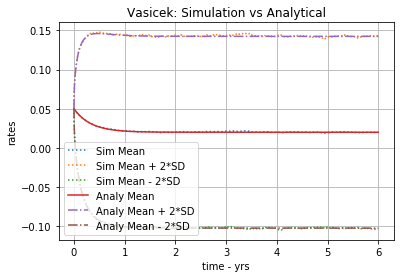

In [13]:
vasicek.PlotEulerSim_Stats("Vasicek: Simulation vs Analytical") 

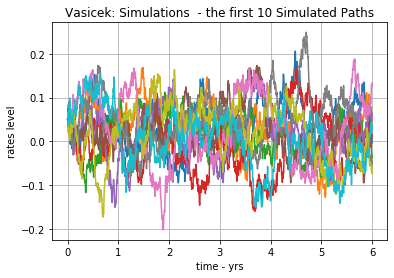

In [14]:
vasicek.PlotEulerSim("Vasicek: Simulations ")

Let's do the same now with the CIR mode and start by using the analytic expression of a zero coupon bond

In [15]:
cir = CIR(theta, kappa, sigma,r0)
print(cir.Exact_zcb(tau))

0.8782268481562675


we can simulate the short rate and calculate the zero coupon bond price

In [16]:
cir.Euler(M, I, tau)
valscir = cir.StochasticPrice(cir.rates, cir.times)

In [17]:
print("the price is:", valscir[0])
print("the price +2sd is :", valscir[1])
print("the price -2sd is :", valscir[2])

the price is: 0.878503643881869
the price +2sd is : 0.878802747370533
the price -2sd is : 0.878204540393205


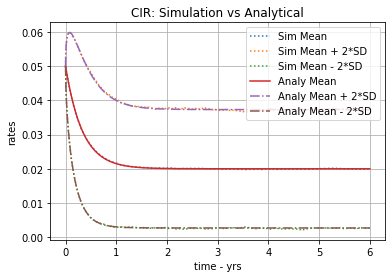

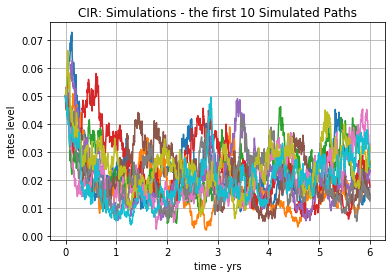

In [18]:
cir.PlotEulerSim_Stats("CIR: Simulation vs Analytical") 
cir.PlotEulerSim("CIR: Simulations" )